Exercise 59

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation

5.1 Graphs

This exercise is about setting up some graphs and getting accustomed to manipulate them. There will be no messages sent, and no trainable parameters on the graphs in this exercise.

5.2 Some graphs

This helper function provides you with edge indices, random node positions, and node values for graphs with all nodes interconnected to each other. num_nodes is the number of nodes in the graph.



In [ ]:
def elements_for_random_graph(num_nodes):
    cutoff = 2.5

    box_size=10
    positions = []
    for i in range(num_nodes):
        new_position = torch.rand(1, 2) * box_size
        if len(positions) > 0:
            all_positions = torch.vstack(positions)
            while torch.any(torch.cdist(all_positions, new_position) < 0.75*cutoff) or \
            torch.all(torch.cdist(all_positions, new_position) > cutoff):
                new_position = torch.rand(1, 2) * box_size        
        positions.append(new_position)

    positions = torch.vstack(positions)

    edge_index = []
    for i in range(len(positions)):
        for j in range(len(positions)):
            edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)
    x = torch.tensor(list(range(num_nodes)),dtype=torch.float32)
    return edge_index, positions, x

a) Call elements_for_random_graph for a 4-node graph

In [49]:
torch.manual_seed(0)
elements = elements_for_random_graph(4)
elements

(tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
         [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]]),
 tensor([[4.9626, 7.6822],
         [3.0742, 6.3408],
         [3.4889, 4.0172],
         [6.9767, 8.0001]]),
 tensor([0., 1., 2., 3.]))

b) Use the output to set up a Torch Geometric graph, graph1.

In [50]:
# Map components from elements
edge_index = elements[0]  # Edge indices (connectivity)
pos = elements[1]         # Random node positions
x = elements[2].unsqueeze(1)  # Node values, reshaped to be compatible as features

# Create the graph data object
graph1 = Data(x=x, edge_index=edge_index, pos=pos)

# Print the graph to verify
print(graph1)

Data(x=[4, 1], edge_index=[2, 16], pos=[4, 2])


c) Repeat b) to get a second Torch Geometric graph, graph2, and plot the two graphs with some code that you write.

In [51]:
torch.manual_seed(1)
elements = elements_for_random_graph(4)
elements

(tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
         [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]]),
 tensor([[7.5763, 2.7931],
         [5.6951, 4.3878],
         [4.1619, 2.8433],
         [3.3978, 5.2394]]),
 tensor([0., 1., 2., 3.]))

In [52]:
# Map components from elements
edge_index = elements[0]  # Edge indices (connectivity)
pos = elements[1]         # Random node positions
x = elements[2].unsqueeze(1)  # Node values, reshaped to be compatible as features

# Create the graph data object
graph2 = Data(x=x, edge_index=edge_index, pos=pos)

# Print the graph to verify
print(graph2)

Data(x=[4, 1], edge_index=[2, 16], pos=[4, 2])


In [53]:
def plot_graph(ax, graph):

    # Plot the nodes:
    for idx, pos in enumerate(graph.pos):
        ax.scatter(pos[0], pos[1], c='C1', s=1000)
        ax.text(pos[0], pos[1], f'{idx}', color='w', ha='center', va='center')    
    
    # Plot the edges:
    for idx, (i1,i2) in enumerate(graph.edge_index.T):
        ax.plot([graph.pos[i1,0], graph.pos[i2,0]], [graph.pos[i1,1], graph.pos[i2,1]], c='black', zorder=0)

    ax.axis('equal')

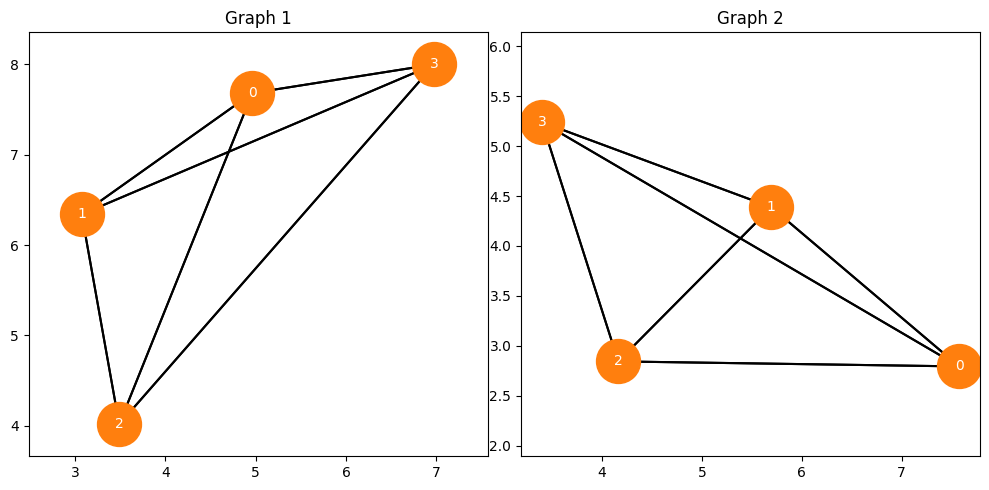

In [56]:
# Define the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns of subplots

# Plot the first graph
plot_graph(axes[0], graph1)
axes[0].set_title("Graph 1")

# Plot the second graph
plot_graph(axes[1], graph2)
axes[1].set_title("Graph 2")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


5.3 Similarity of graphs

d) Write a function that will tell if two graphs are most likely identical according to the sorted eigenvalues of the adjacency matrix. Check if graph1 and graph2 are identical.

In [ ]:
# Using the sorted eigenvals of the adjacency matrices, we check if the graphs are probably identical

def graphs_are_identical(graph1, graph2):
    adj_matrix1 = to_dense_adj(graph1.edge_index)
    eig1 = np.linalg.eigvalsh(adj_matrix1)
    sorted_eig1 = np.sort(eig1)

    adj_matrix2 = to_dense_adj(graph2.edge_index)
    eig2 = np.linalg.eigvalsh(adj_matrix2)
    sorted_eig2 = np.sort(eig2)

    are_identical = np.allclose(sorted_eig1, sorted_eig2)
    return are_identical

print(graphs_are_identical(graph1,graph2))

True


e) Write a function that receives the edge_index and positions that you get from elements_for_random_graph and returns a new edge_index that only contains indices for edges that are shorter than 2.5.

In [77]:
def keep_short_edges(edge_index, positions):
    edge_index_to_keep = []
    for edge in edge_index.T:
        source = positions[edge[0]]
        target = positions[edge[1]]
        
        # Compute the Euclidean distance between source and target positions
        distance = torch.norm(source - target)
        
        # Keep the edge if the distance is less than 2.5
        if distance < 2.5:
            edge_index_to_keep.append(edge.tolist())
    
    # Convert the list of edges back to a tensor and transpose to match edge_index format
    return torch.tensor(np.array(edge_index_to_keep).T, dtype=torch.long)


In [78]:
# Example usage
# Assuming elements[0] is edge_index and elements[1] is positions from elements_for_random_graph
edge_index = elements[0]
positions = elements[1]

# Get the filtered edge_index
new_edge_index = keep_short_edges(edge_index, positions)
print(new_edge_index)

tensor([[0, 0, 1, 1, 1, 1, 2, 2, 3, 3],
        [0, 1, 0, 1, 2, 3, 1, 2, 1, 3]])


f) Make a function that first calls elements_for_random_graph, and then calls your function from e), and finally returns a Torch Geometric graph object, where now only edges shorter than 2.5 are retained.

In [ ]:
def random_graph(num_nodes):
    # Call elements_for_random_graph to generate graph components
    edge_index, positions, node_values = elements_for_random_graph(num_nodes)
    
    # Retain only edges shorter than 2.5
    edge_index = keep_short_edges(edge_index, positions)
    
    # Create the PyTorch Geometric graph object
    graph = Data(x=node_values.unsqueeze(1), edge_index=edge_index, pos=positions)
    
    return graph


Data(x=[4, 1], edge_index=[2, 10], pos=[4, 2])


g) Call random_graph twice and plot the two graphs.




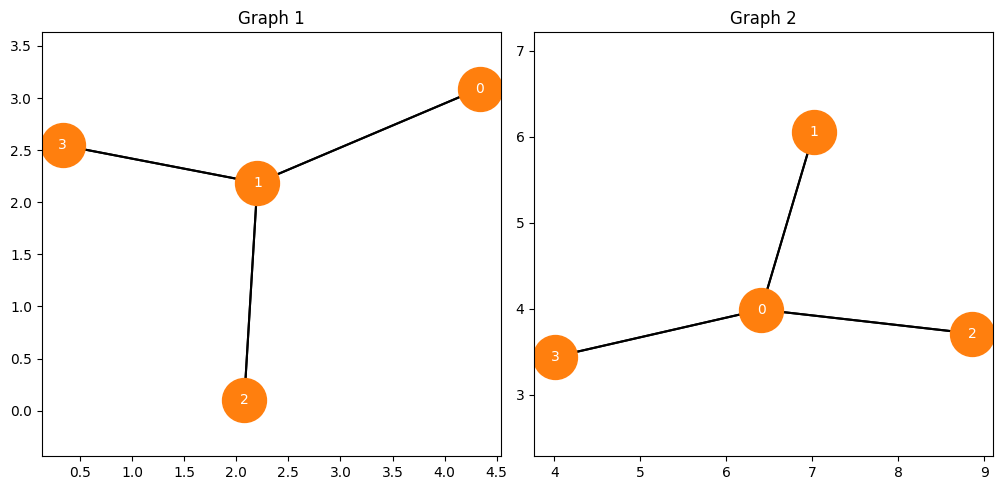

In [83]:
num_nodes = 4
graph1 = random_graph(num_nodes)
graph2 = random_graph(num_nodes)

# Define the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns of subplots

# Plot the first graph
plot_graph(axes[0], graph1)
axes[0].set_title("Graph 1")

# Plot the second graph
plot_graph(axes[1], graph2)
axes[1].set_title("Graph 2")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


h) Check if the two graphs are identical according to the criterion involving the sorted eigenvalue spectra.

In [93]:
are_identical = graphs_are_identical(graph1,graph2)
if are_identical:
    print('The two graphs are identical') 
else:
    print('The two graphs are not identical')


The two graphs are identical


i) Create very many random graphs with 5 nodes. Keep those with unique graphs in a list. Plot the graphs eventually. Now many distinct graphs can you find?


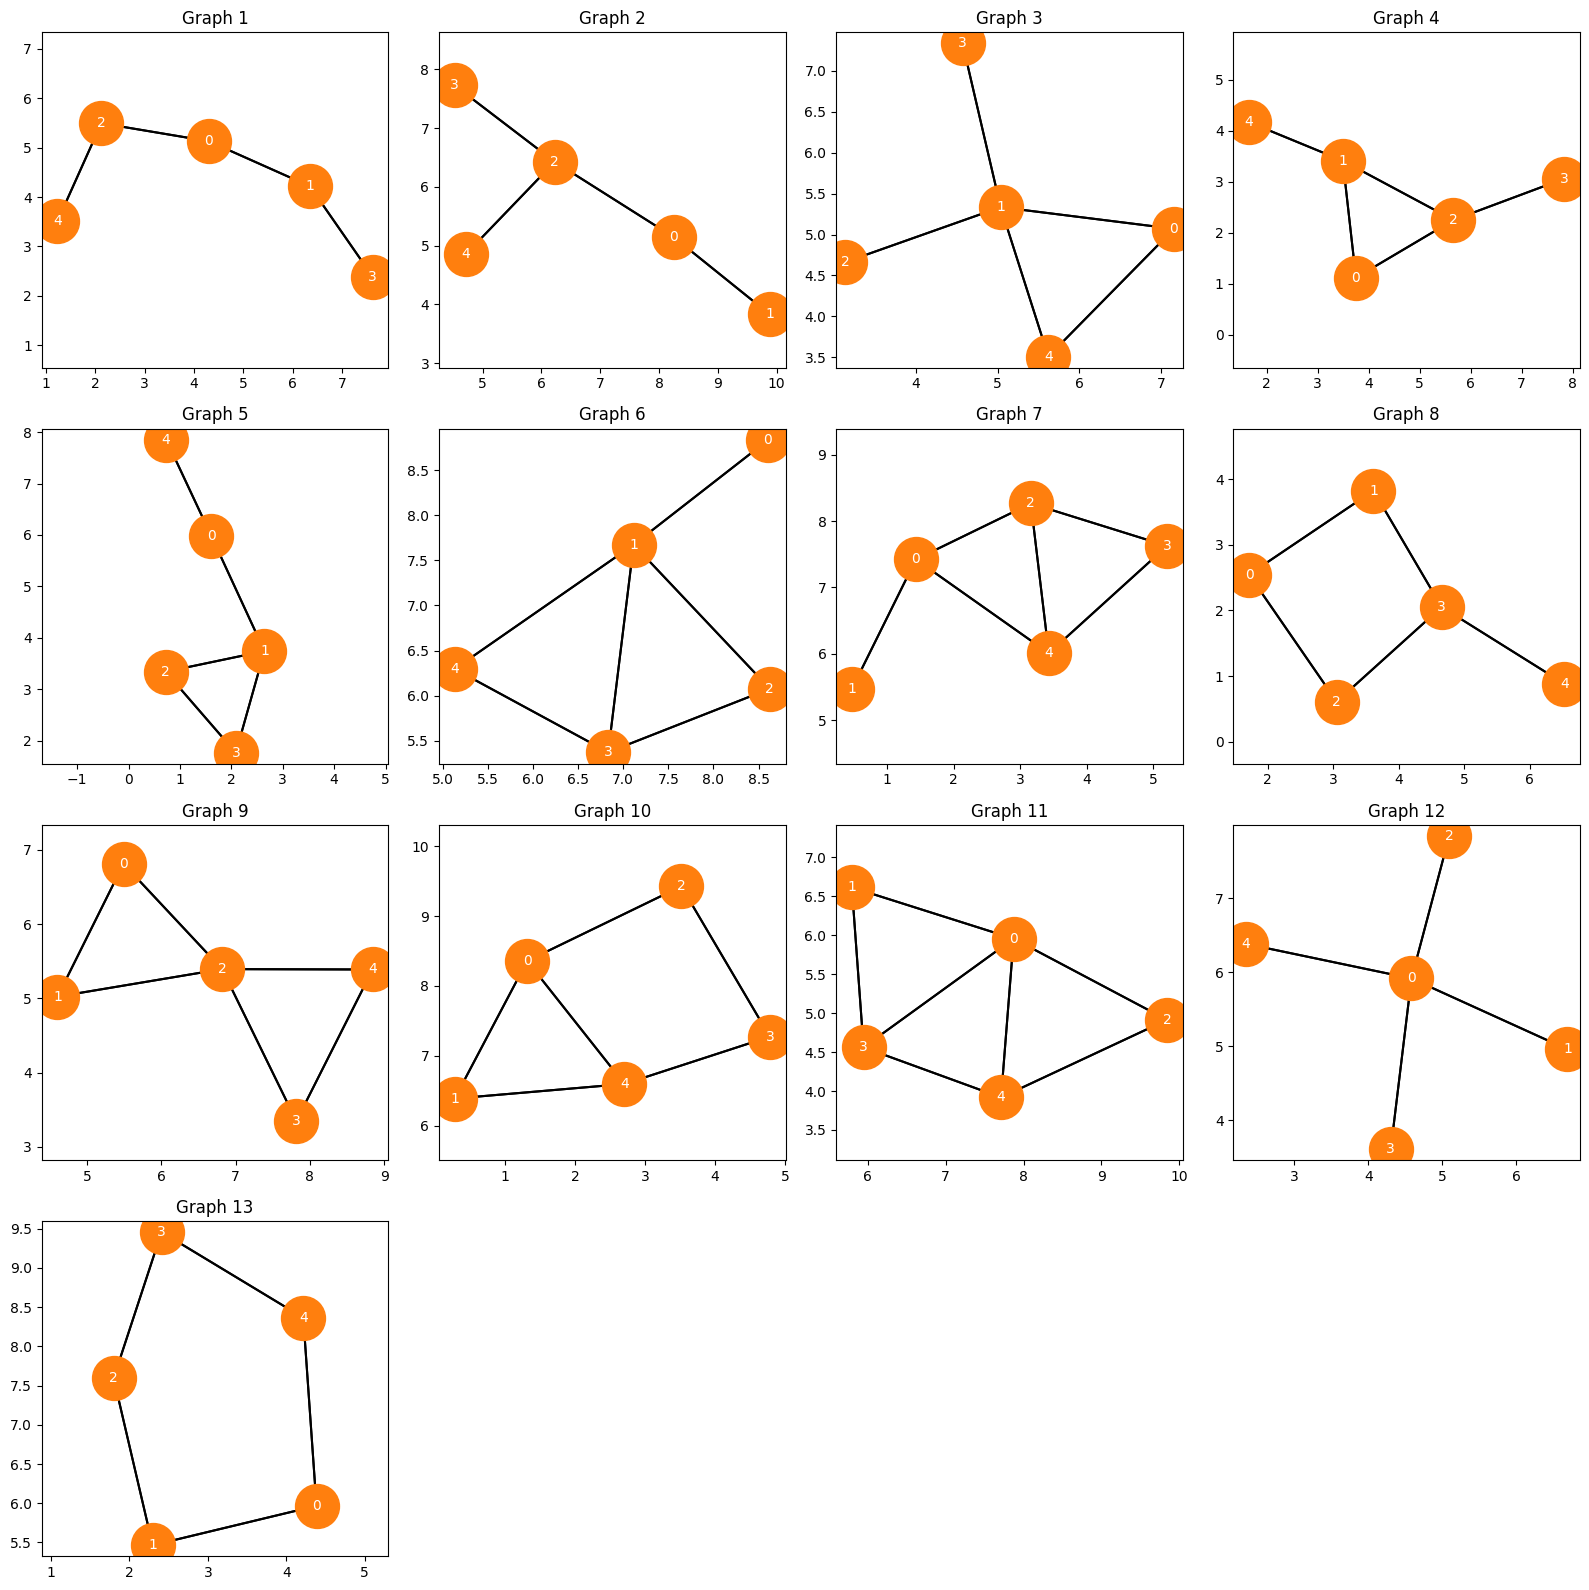

In [ ]:
num_nodes = 5
unique_5_node_graphs = []

# Generate unique graphs
for i in range(500):
    new_graph = random_graph(num_nodes)
    unique = True
    for j in range(len(unique_5_node_graphs)):
        if graphs_are_identical(new_graph, unique_5_node_graphs[j]):
            unique = False
    if unique:
        unique_5_node_graphs.append(new_graph)

# Define the number of rows and columns
num_cols = 4
num_rows = (len(unique_5_node_graphs) + num_cols - 1) // num_cols  # Calculate rows needed

# Define the figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))

# Flatten axes for easy iteration if there are multiple rows
axes = axes.flatten()

# Plot each unique graph
for k, graph in enumerate(unique_5_node_graphs):
    plot_graph(axes[k], graph)
    axes[k].set_title(f"Graph {k + 1}")

# Hide unused subplots
for k in range(len(unique_5_node_graphs), len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()
